In [1]:
import sys
import os
# caution: path[0] is reserved for script path (or '' in REPL)
os.environ['MUJOCO_PY_MUJOCO_PATH']='/scratch_net/biwidl310/rl_course_18/mujoco/mujoco210'

#add DiffuseDrive to path. Dont know why, but else diffuser folder is not seen.
# os.environ['PYTHONPATH'] = str(os.environ['PYTHONPATH']) + '~/DiffuseDrive'

import diffuser.utils as utils
import torch
import wandb
# logging.basicConfig(filename='logs/training.log', encoding='utf-8', level=logging.INFO)
from logger_module import logger
from tqdm import tqdm

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
2023-05-31 18:28:15,678 - INFO - MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.
2023-05-31 18:28:15,680 - INFO - Successfully imported OpenGL backend: glfw
2023-05-31 18:28:15,696 - INFO - MuJoCo library version is: 2.3.5
pybullet build time: May  5 2023 13:52:43
/scratch_net/biwidl310/rl_course_18/conda_envs/plan_diffuse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_config = utils.Config(
    'datasets.CollectedSequenceDataset',
    savepath='dataset_config.pkl',
    env='carla-expert',
    horizon=12,
    normalizer='CDFNormalizer',
    preprocess_fns=[],
    use_padding=True,
    max_path_length=10,
    include_returns=True,
    returns_scale=400,
    discount=0.99,
    termination_penalty=-100,
    past_image_cond = False, 
    is_valid=True,
)


dataset = dataset_config()

[ utils/config ] Imported diffuser.datasets:CollectedSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CollectedSequenceDataset'>
    discount: 0.99
    env: carla-expert
    horizon: 12
    include_returns: True
    is_valid: True
    max_path_length: 10
    normalizer: CDFNormalizer
    past_image_cond: False
    preprocess_fns: []
    returns_scale: 400
    termination_penalty: -100
    use_padding: True

[ utils/config ] Saved config to: dataset_config.pkl



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import json

In [10]:
next(iter(dataset))

ValidBatch(trajectories=array([[ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [-7.4478532e-03, -6.5878528e-01, -4.1165347e-03],
       [-2.0420432e-02, -2.8622906e+00, -6.6204066e-03],
       [-4.9166575e-02, -5.3869982e+00, -9.6855154e-03],
       [-2.7750012e-02, -7.0919948e+00,  9.5190583e-03]], dtype=float32), conditions=array([[ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00, -2.8421706e-14],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32), birdview=array([[[0

In [30]:
def transform_2d_points(xyz, r1, t1_x, t1_y, r2, t2_x, t2_y):
        """
        Build a rotation matrix and take the dot product.
        """
        # z value to 1 for rotation
        xy1 = xyz.copy()
        xy1[:, 2] = 1
        xy1_front = xy1.copy()
        xy1_front[:,0] += 1.0

        c, s = np.cos(r1), np.sin(r1)
        r1_to_world = np.matrix([[c, s, t1_x], [-s, c, t1_y], [0, 0, 1]])

        # np.dot converts to a matrix, so we explicitly change it back to an array
        world = np.asarray(r1_to_world @ xy1.T)
        world_front = np.asarray(r1_to_world @ xy1_front.T)

        c, s = np.cos(r2), np.sin(r2)
        r2_to_world = np.matrix([[c, s, t2_x], [-s, c, t2_y], [0, 0, 1]])
        world_to_r2 = np.linalg.inv(r2_to_world)

        out = np.asarray(world_to_r2 @ world).T
        out_front = np.asarray(world_to_r2 @ world_front).T
        # reset z-coordinate
        out[:, 2] = np.arctan2(out_front[:,1]-out[:,1], out_front[:,0] - out[:,0])

        return out

##here gps:=ego wp
def convert_gps_to_ego(gps_waypoints, current_gps_waypoint):
        ego_waypoint = [None] * len(gps_waypoints)
        for t in range(len(gps_waypoints)):
            if not isinstance(gps_waypoints[t], np.ndarray):
                break

            ego_waypoint[t] = transform_2d_points(
                np.zeros((1,3)),
                np.pi / 2 - gps_waypoints[t][2],
                    -gps_waypoints[t][0],
                    -gps_waypoints[t][1],
                    np.pi / 2 - current_gps_waypoint[2],
                    -current_gps_waypoint[0],
                    -current_gps_waypoint[1],
            )
        return ego_waypoint

In [6]:
## birdview size=(400,400), ego vihecle is centered
def vis_with_bev(bev_img, traj, color):
    ## Set up figure
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (6,6)
    margin_max = 400  #sample_t.max()+1
    margin_min = 0   #sample_t.min()-1
    norm = plt.Normalize(margin_min, margin_max)
    ax.set_xlim(margin_min, margin_max)
    ax.set_ylim(margin_min, margin_max)
    img = Image.fromarray(bev_img)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    img = img.resize((500,500))
    
    ax.imshow(img, extent=[0,500,0,500])

    ## for color display
    length = len(traj)*2
    print(traj)
    for i, poses in enumerate(traj):
        dx = np.cos(poses[-1]-np.pi/2)/5
        dy = np.sin(poses[-1]-np.pi/2)/5
        # ,alpha=0.5+i/length
        #waypoint = np.around(poses*5+20*10).astype(int)
        waypoint = poses*5+250
        #pos_0 = (poses[0]+offset)
        ax.scatter(waypoint[0], waypoint[1],s=10, color=color, alpha=0.5+i/length)
        if i == 11:
            ax.arrow(waypoint[0], waypoint[1], dx, dy, head_width=7, color='blue',alpha=0.5+i/length)
        if i== 3:
            ax.text(waypoint[0]-0.05, waypoint[1]+0.05, 'c', fontsize=10)
        #ax.text(poses[0]-0.05+offset, poses[1]+0.05+offset, i, fontsize=15)
    ## In actual use: plt.savefig
    plt.show()


25
[[ 6.90686256e-02  6.76410389e+00 -2.08420679e-02]
 [ 1.81855354e-02  4.21972561e+00 -1.87616274e-02]
 [-5.90308104e-04  1.99422228e+00 -1.29218036e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.63403284e-02 -1.97805238e+00  4.44609253e-03]
 [ 7.05569703e-03 -3.96611428e+00 -2.77359853e-03]
 [-7.16907755e-02 -5.94308805e+00 -4.23927195e-02]
 [-3.28527272e-01 -7.91332865e+00 -1.21149525e-01]
 [-8.10857356e-01 -9.83937645e+00 -2.35867471e-01]
 [-1.56265640e+00 -1.16811399e+01 -3.68001431e-01]
 [-2.58628964e+00 -1.33828230e+01 -5.20005167e-01]
 [-3.90672731e+00 -1.48701496e+01 -7.01178491e-01]]


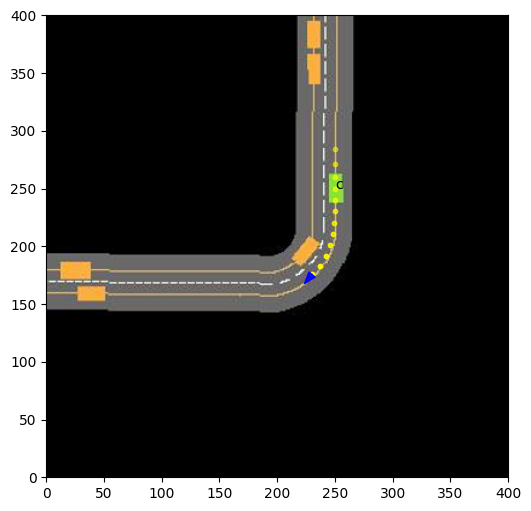

In [9]:
i=0
samples = []
for data in dataset:
    sample_t, _, birdview = data
    if  25<=i<=30 and i%5==0:
        print(i)
        #img = Image.open("../birdview/%04d.jpg"%(i+3))
        vis_with_bev(birdview, sample_t, "yellow")
        #print(sample_t)
        #samples.append(sample_t)
        time.sleep(1)
    i+=1
    if i==30: 
        break
#img = Image.open("../birdview/0058.jpg")
#vis_with_bev(img, sample_t, "purple")

In [73]:
i=150
img=Image.open("../birdview/%04d.jpg"%i)
path = "../sample_test/weather-0/data/routes_town02_long_w0_04_16_17_24_03/measurements/"

sample_x = []
sample_y = []
sample_z = []
while i<=180:
    data = json.load(open(path+"%04d.json"%i))
    sample_x.append(data.get("gps_x"))
    sample_y.append(data.get("gps_y"))
    sample_z.append(data.get("theta"))
    i+=1

In [74]:
sample_x_a = np.array(sample_x)
sample_y_a = np.array(sample_y)
sample_z_a = np.array(sample_z)
samples = np.hstack([sample_x_a[:,np.newaxis], sample_y_a[:,np.newaxis], sample_z_a[:,np.newaxis]])

In [75]:
ego_samples = convert_gps_to_ego(samples, samples[0])
ego_samples = np.array(ego_samples).reshape((-1,3))

250.0
250.0


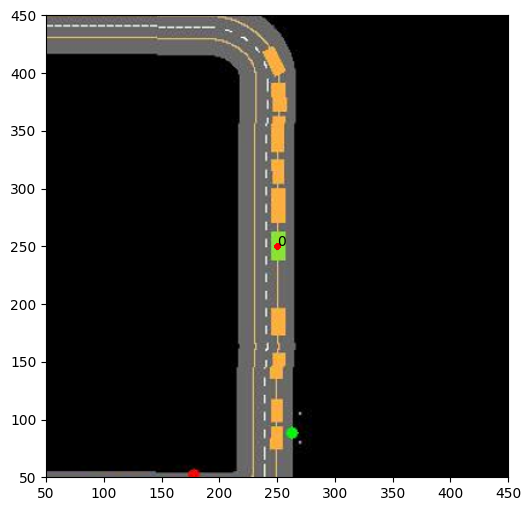

In [77]:
#samples = np.concatenate(sample_x_a, sample_y_a)

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (6,6)
margin_max = 450  #sample_t.max()+1
margin_min = 50   #sample_t.min()-1
norm = plt.Normalize(margin_min, margin_max)
ax.set_xlim(margin_min, margin_max)
ax.set_ylim(margin_min, margin_max)
img1 = img.transpose(Image.FLIP_TOP_BOTTOM)
img1 = img1.resize((500,500))
ax.imshow(img1, extent=[0,500,0,500])

## for color display
length = len(sample_x)*2

for i, poses in enumerate(ego_samples):
    dx = np.cos(poses[-1]-np.pi/2)/5
    dy = np.sin(poses[-1]-np.pi/2)/5
    # ,alpha=0.5+i/length
    waypoint = poses*5+250
    #pos_0 = (poses[0]+offset)
    ax.scatter(waypoint[0], waypoint[1],s=10, color='red', alpha=0.5+i/length)
    if i == 11:
        ax.arrow(waypoint[0], waypoint[1], dx, dy, head_width=2, color='blue',alpha=0.5+i/length)
    if i== 0:
        ax.text(waypoint[0]-0.05, waypoint[1]+0.05, i, fontsize=10)
        print(waypoint[0])
        print(waypoint[1])
    #ax.text(poses[0]-0.05+offset, poses[1]+0.05+offset, i, fontsize=15)
## In actual use: plt.savefig
plt.show()

In [53]:
traj_samples = []
i=1
traj_samples.append(samples[0])
traj_samples.append(convert_ego_to_gps(samples[0], np.array([-130.995,
193.721, 6.27191781997])))

In [54]:
traj_samples[0]

array([[ 6.90686256e-02,  6.76410389e+00, -2.08420679e-02],
       [ 1.81855354e-02,  4.21972561e+00, -1.87616274e-02],
       [-5.90308104e-04,  1.99422228e+00, -1.29218036e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.63403284e-02, -1.97805238e+00,  4.44609253e-03],
       [ 7.05569703e-03, -3.96611428e+00, -2.77359853e-03],
       [-7.16907755e-02, -5.94308805e+00, -4.23927195e-02],
       [-3.28527272e-01, -7.91332865e+00, -1.21149525e-01],
       [-8.10857356e-01, -9.83937645e+00, -2.35867471e-01],
       [-1.56265640e+00, -1.16811399e+01, -3.68001431e-01],
       [-2.58628964e+00, -1.33828230e+01, -5.20005167e-01],
       [-3.90672731e+00, -1.48701496e+01, -7.01178491e-01]], dtype=float32)

In [55]:
traj_samples[1]

[array([[-1.85468297e+02, -1.33162239e+02, -9.57458069e-03]]),
 array([[-1.88013087e+02, -1.33140027e+02, -7.49414017e-03]]),
 array([[-1.90238661e+02, -1.33146328e+02, -1.65431642e-03]]),
 array([[-1.92232750e+02, -1.33169387e+02,  1.12674872e-02]]),
 array([[-1.94210493e+02, -1.33208014e+02,  1.57135797e-02]]),
 array([[-1.96198533e+02, -1.33221130e+02,  8.49388867e-03]]),
 array([[-1.98176268e+02, -1.33164664e+02, -3.11252323e-02]]),
 array([[-2.00149278e+02, -1.32930042e+02, -1.09882038e-01]]),
 array([[-202.08063783, -132.46944429,   -0.22459998]]),
 array([[-203.93075512, -131.73844458,   -0.35673394]]),
 array([[-205.64386368, -130.7340496 ,   -0.50873768]]),
 array([[-207.14597359, -129.43045382,   -0.689911  ]])]

In [ ]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [ ]:
dataloader = cycle(torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers=0, pin_memory=True, shuffle = False
))

In [ ]:
tmp = next(dataloader)


In [ ]:
print(tmp[0])
print(tmp[0][0,:,:-1]) # x and y coordinates

In [ ]:
all_zeros_count = 0
for i, data in enumerate(tqdm(dataloader)):
    # print(i)
    # print(data[0].max())
    # print(data[0])
    if data[0][0,:,:-1].max() <= 1e-6:
        all_zeros_count += 1
    
    if i > 50000:
        break

In [ ]:
print(all_zeros_count)
print(i)

In [ ]:
print(all_zeros_count/(i+1))